In [9]:
from Data_tools import *

In [10]:
l_ckd_codes = ckd_codes.icd_code.to_list()
query = f"""
    SELECT 
        di.subject_id, 
        di.icd_code, 
        p.anchor_age + EXTRACT(YEAR FROM (CAST (a.admittime AS DATE))) - p.anchor_year as diagnosis_age, 
        CAST (a.admittime AS DATE) as diagnosis_date
    FROM 
        hosp.diagnoses_icd di
    JOIN 
        hosp.d_icd_diagnoses did ON di.icd_code = did.icd_code
    JOIN 
        hosp.patients p ON di.subject_id = p.subject_id
    JOIN 
        hosp.admissions a ON di.hadm_id = a.hadm_id
    WHERE 
        di.icd_code in {sqlify(l_ckd_codes)};
"""

df = execute_query(query, **params) 
df

,subject_id,icd_code,diagnosis_age,diagnosis_date
0,10000980,N184,80.0,2193-08-15
1,10000980,5854,77.0,2190-11-06
2,10000980,5854,78.0,2191-04-03
3,10000980,N184,78.0,2191-05-23
4,10000980,5854,76.0,2189-06-27
...,...,...,...,...
33854,19977310,5856,71.0,2152-11-17
33855,19977310,40391,71.0,2152-11-17
33856,19980334,5854,87.0,2115-02-12
33857,19991805,5854,85.0,2143-01-26


In [11]:
add_simple_diagnosis(df)
# Display the updated DataFrame
df

,subject_id,icd_code,diagnosis_age,diagnosis_date,simplified_diagnosis
0,10000980,N184,80.0,2193-08-15,Stage 4
1,10000980,5854,77.0,2190-11-06,Stage 4
2,10000980,5854,78.0,2191-04-03,Stage 4
3,10000980,N184,78.0,2191-05-23,Stage 4
4,10000980,5854,76.0,2189-06-27,Stage 4
...,...,...,...,...,...
33854,19977310,5856,71.0,2152-11-17,Stage 5
33855,19977310,40391,71.0,2152-11-17,CKD with other diseases
33856,19980334,5854,87.0,2115-02-12,Stage 4
33857,19991805,5854,85.0,2143-01-26,Stage 4


C:\Users\nlerouxm\AppData\Local\Temp\6\ipykernel_21348\1243911306.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df[df['simplified_diagnosis'] == diagnosis], x='diagnosis_age', label=diagnosis, fill=True, common_norm=False, palette='muted', alpha=0.5)
C:\Users\nlerouxm\AppData\Local\Temp\6\ipykernel_21348\1243911306.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df[df['simplified_diagnosis'] == diagnosis], x='diagnosis_age', label=diagnosis, fill=True, common_norm=False, palette='muted', alpha=0.5)
C:\Users\nlerouxm\AppData\Local\Temp\6\ipykernel_21348\1243911306.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df[df['simplified_diagnosis'] == diagnosis], x='diagnosis_age', label=diagnosis, fill=True, common_norm=False, palette='muted', alpha=0.5)


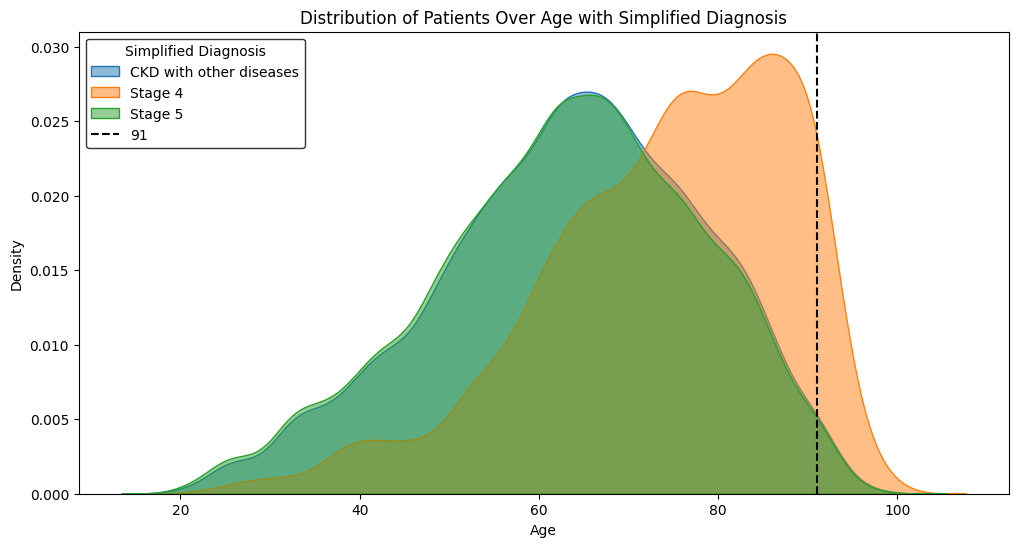

In [12]:
# Pivot the DataFrame based on simplified_diagnosis
pivot_df = df.pivot_table(index='diagnosis_age', columns='simplified_diagnosis', aggfunc='size', fill_value=0)

# Plot the KDE histogram with hue as simplified_diagnosis
plt.figure(figsize=(12, 6))
for diagnosis in pivot_df.columns:
    sns.kdeplot(data=df[df['simplified_diagnosis'] == diagnosis], x='diagnosis_age', label=diagnosis, fill=True, common_norm=False, palette='muted', alpha=0.5)

# Add titles and labels
plt.title('Distribution of Patients Over Age with Simplified Diagnosis')
plt.xlabel('Age')
plt.ylabel('Density')

plt.axvline(91, color='black', linestyle='--', label="91")


# Customize the legend
plt.legend(title='Simplified Diagnosis', frameon=True, edgecolor='black')

# Show the plot
plt.show()

___
## Selects the measurements with a certain anteriority relatively to a diagnosis

In [13]:
# Number of lines to select
n = 1000000000

# Anteriority of the measures relatively to the diagnosis (in days)
anteriority = 7

# Tolerance for the anteriority
tol = 1

In [14]:
l_ckd_codes = ckd_codes.icd_code.to_list()
#query = f"SELECT di.subject_id, di.icd_code, did.long_title, p.anchor_age + EXTRACT(YEAR FROM (CAST (a.admittime AS DATE))) - p.anchor_year as diagnosis_age, CAST (a.admittime AS DATE) as diagnosis_date FROM hosp.diagnoses_icd di JOIN hosp.d_icd_diagnoses did ON di.icd_code = did.icd_code JOIN hosp.patients p ON di.subject_id = p.subject_id JOIN hosp.admissions a ON di.hadm_id = a.hadm_id WHERE di.icd_code in {sqlify(l_ckd_codes)};"

print("analysis codes : " + sqlify(analysis_codes))
print("time interval : " + sqlify([0.95*anteriority, 1.05*anteriority]))

#p.adimttime correspond au timestamp pour l'admission au cours de laquelle a eu lieu le diagnostic

query = f"""
SELECT 
    p.subject_id,
    p.anchor_age + EXTRACT(YEAR FROM MIN(CAST(l.storetime AS DATE))) - p.anchor_year AS "Patient age", 
    CAST(p.admittime AS DATE) - MIN(CAST(l.storetime AS DATE)) AS time_difference,
    l.specimen_id,

    -- Pivoted measurements using MAX() with FILTER
    MAX(l.valuenum) FILTER (WHERE dl.label = 'Creatinine') AS "Creatinine",
    MAX(l.valuenum) FILTER (WHERE dl.label = 'Urea Nitrogen') AS "Urea nitrogen",
    MAX(l.valuenum) FILTER (WHERE dl.label = 'Potassium') AS "Potassium",
    MAX(l.valuenum) FILTER (WHERE dl.label = 'Albumin') AS "Albumin",

    p.icd_code 

FROM hosp.labevents l 
JOIN hosp.d_labitems dl ON l.itemid = dl.itemid 
JOIN (
    SELECT 
        di.subject_id, 
        p.anchor_age,
        p.anchor_year,
        a.admittime,
        di.icd_code 
    FROM hosp.diagnoses_icd di 
    JOIN hosp.d_icd_diagnoses did ON di.icd_code = did.icd_code 
    JOIN hosp.patients p ON di.subject_id = p.subject_id 
    JOIN hosp.admissions a ON di.hadm_id = a.hadm_id 
    WHERE di.icd_code IN {sqlify(l_ckd_codes)}
) AS p ON l.subject_id = p.subject_id 

WHERE l.itemid IN {sqlify(analysis_codes)}
    AND (CAST(p.admittime AS DATE) - CAST(l.storetime AS DATE)) <= {(1+tol)*anteriority}
    AND (CAST(p.admittime AS DATE) - CAST(l.storetime AS DATE)) >= {(1-tol)*anteriority}

GROUP BY p.subject_id, p.anchor_age, p.anchor_year, l.specimen_id, p.admittime, p.icd_code 

LIMIT {n};
"""
df = execute_query(query, **params)
add_simple_diagnosis(df)
df

analysis codes : ('50862', '50912', '0', '50971', '51006')
time interval : (6.6499999999999995, 7.3500000000000005)


,subject_id,Patient age,time_difference,specimen_id,Creatinine,Urea nitrogen,Potassium,Albumin,icd_code,simplified_diagnosis
0,10000980,77.0,4,25528532,2.7,44.0,4.4,4.3,5854,Stage 4
1,10000980,77.0,12,39366163,2.1,36.0,4.3,3.9,5854,Stage 4
2,10000980,76.0,0,46753637,2.3,37.0,3.9,NaN,5854,Stage 4
3,10000980,78.0,0,52441038,2.3,39.0,5.4,NaN,N184,Stage 4
4,10000980,80.0,1,63265608,2.4,38.0,4.8,NaN,N184,Stage 4
...,...,...,...,...,...,...,...,...,...,...
91316,19993776,85.0,0,13383628,3.8,125.0,3.4,NaN,40391,CKD with other diseases
91317,19993776,85.0,0,13383628,3.8,125.0,3.4,NaN,5855,Stage 5
91318,19993776,85.0,1,18009452,3.7,83.0,4.6,NaN,5854,Stage 4
91319,19993776,85.0,0,83876948,3.7,81.0,3.8,NaN,5854,Stage 4


## Separates the different measurements in column

## Plots the distribution of the measurements for each diagnosis groups (hue)

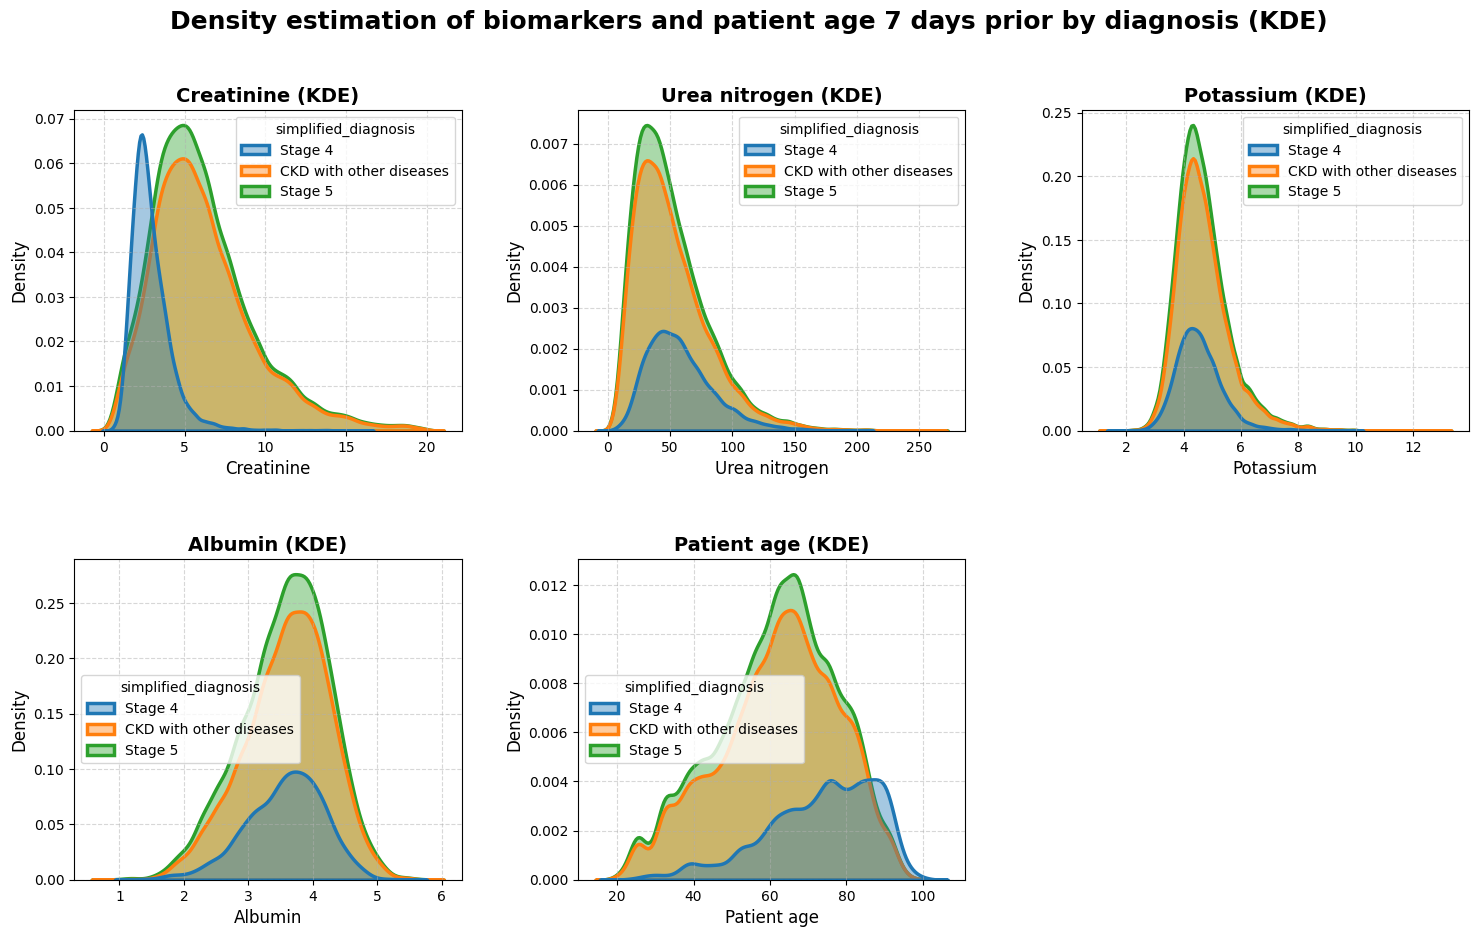

In [15]:
# Define variables to plot
#variables = ["Creatinine", "Urea Nitrogen", "Potassium", "Albumin", "patient_age"]
variables = ["Creatinine", "Urea nitrogen", "Potassium", "Albumin", "Patient age"]
titles = ["Creatinine", "Urea nitrogen", "Potassium", "Albumin", "Patient age"]

# Define color palettes
hist_palette = "Set2"  
kde_palette = "coolwarm"
kde_palette = "tab10"  


### ---- FIGURE 2: FILLED KDE PLOTS ---- ###

# Preparation of datas :
inf = np.inf
threshold = {"Creatinine" : 20, "Urea nitrogen" : inf, "Potassium" : inf, "Albumin" : inf, "Patient age" : inf} 

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
axes2 = axes2.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, var in enumerate(variables):
    ax = axes2[i]
    filtered_df = df
    # Apply filtering only if threshold is finite
    if np.isfinite(threshold[var]):
        filtered_df = df[df[var] < threshold[var]]  # Apply threshold filtering
    else:
        filtered_df = df  # No filtering for variables with inf threshold
    sns.kdeplot(
        data=filtered_df, x=var, hue=df["simplified_diagnosis"], ax=ax, 
        palette=kde_palette, fill=True, alpha=0.4, linewidth=2.5  # Increase line width and adjust alpha
    )
    ax.set_title(f"{titles[i]} (KDE)", fontsize=14, fontweight="bold")
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)


fig2.delaxes(axes2[-1])  # Remove empty subplot if needed
plt.suptitle(f"Density estimation of biomarkers and patient age {anteriority} days prior by diagnosis (KDE)", fontsize=18, fontweight="bold")
plt.show()


Explained Variance Ratio: [0.29515491 0.21794687]


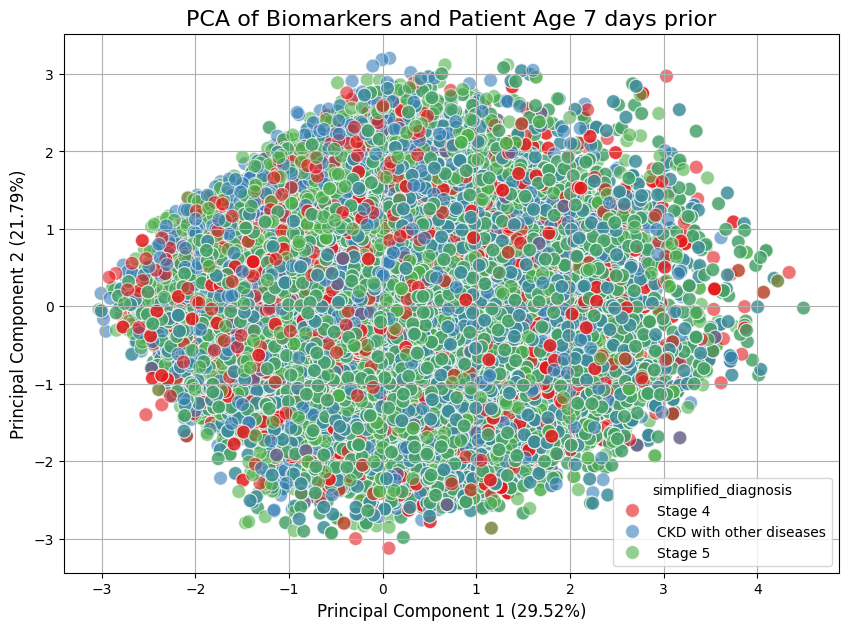


PCA Loadings (Coefficients) for each principal component:
     Creatinine  Urea nitrogen  Potassium   Albumin  Patient age
PC1    0.641874       0.435959   0.480707  0.060815    -0.403930
PC2   -0.196032       0.576707   0.330469  0.080928     0.716395


In [16]:
# Step 0 : prepare the data :
df = impute_missing_values(df)

# Define the columns to scale
columns_to_study = ["Creatinine", "Urea nitrogen", "Potassium", "Albumin", "Patient age"]
columns_to_keep = [col for col in df.columns if col not in columns_to_study]  # Other columns


# Loop through each column and filter out values outside the 5th and 95th percentiles
for col in columns_to_study:
    lower_bound = df[col].quantile(0.05)
    upper_bound = df[col].quantile(0.95)
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Step 1: Standardize the data
        # Initialize the scaler
scaler = StandardScaler()

    # Scale only the selected columns
df_scaled = df.copy()
df_scaled[columns_to_study] = scaler.fit_transform(df_scaled[columns_to_study])

# Step 2: Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled[columns_to_study])

# Step 3: Create DataFrame with PCA results
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['simplified_diagnosis'] = df_scaled['simplified_diagnosis']  # Add the diagnosis column

# Step 4: Output the explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Step 5: Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='simplified_diagnosis', palette='Set1', s=100, alpha=0.6)
plt.title(f"PCA of Biomarkers and Patient Age {anteriority} days prior", fontsize=16)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}%)", fontsize=12)
plt.grid(True)
plt.show()

# Step 6: Display the loadings (coefficients) of each feature in the principal components
loadings = pd.DataFrame(pca.components_, columns=df_scaled[columns_to_study].columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print("\nPCA Loadings (Coefficients) for each principal component:")
print(loadings)


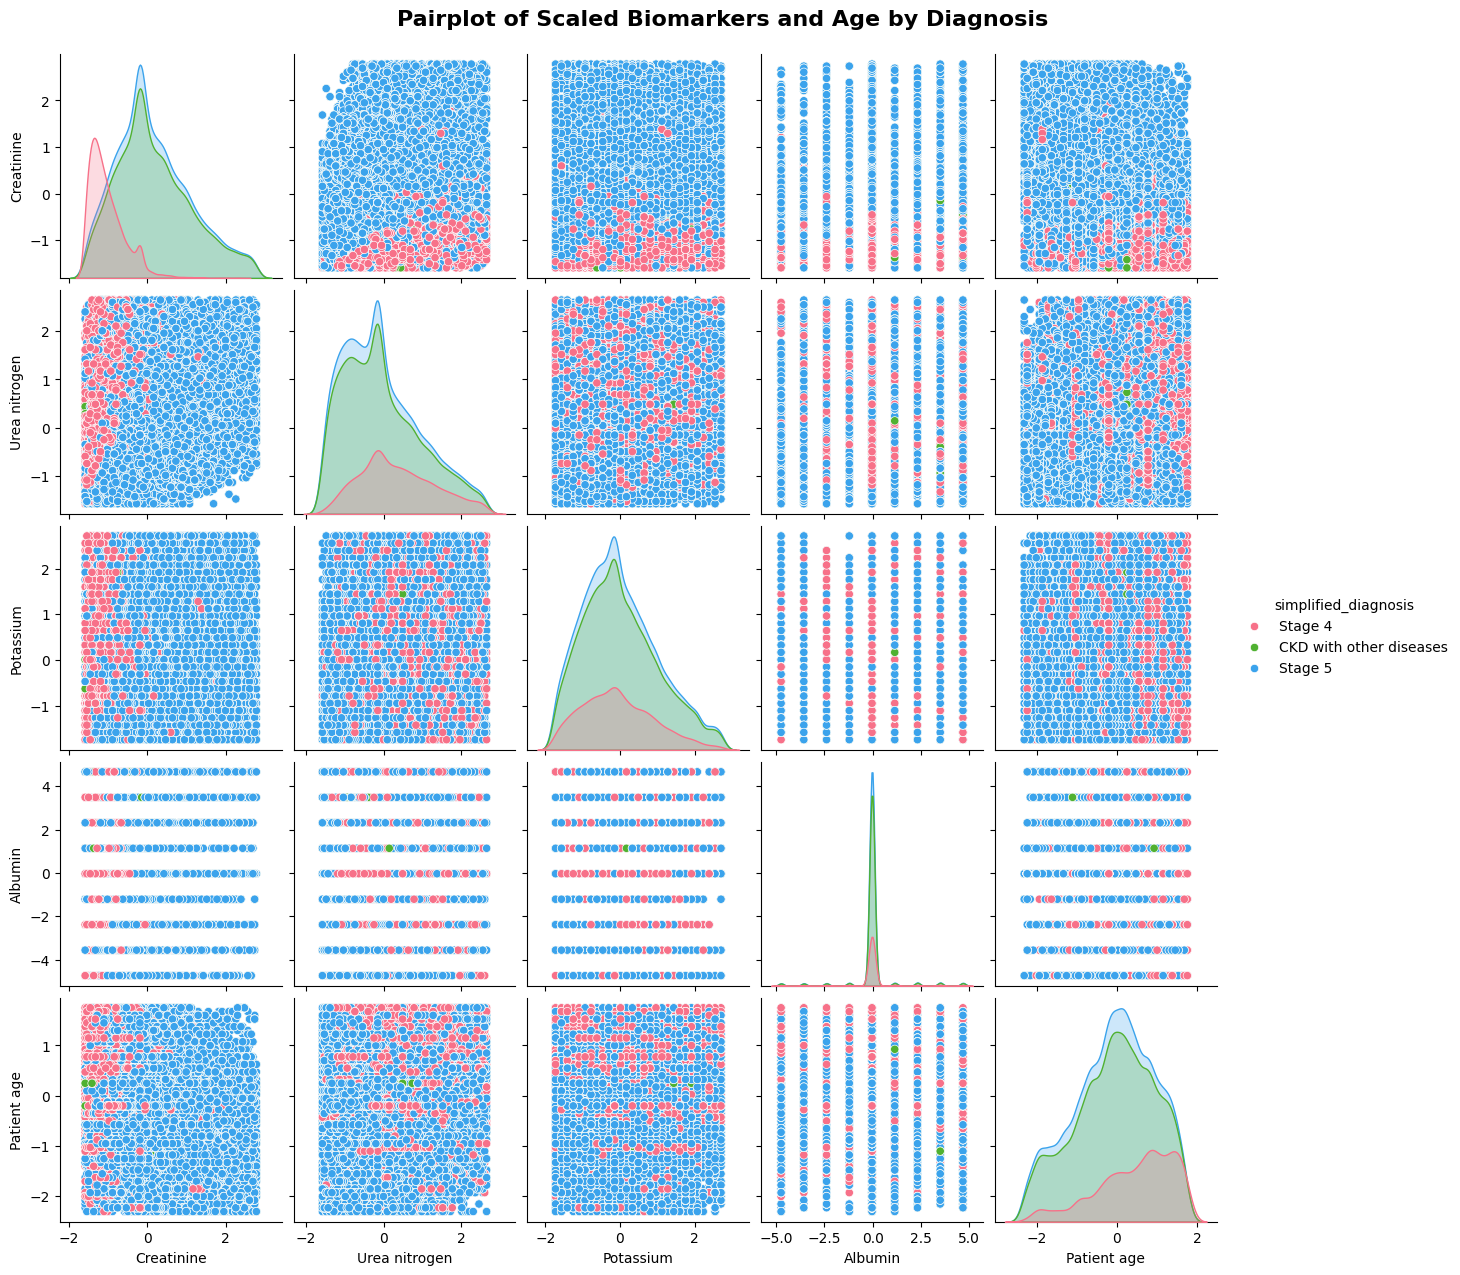

In [17]:
# Selecting only the numerical features to plot
features_to_plot = ["Creatinine", "Urea nitrogen", "Potassium", "Albumin", "Patient age"]
df_plot = df_scaled[features_to_plot + ["simplified_diagnosis"]]

# Create the pairplot
sns.pairplot(df_plot, hue="simplified_diagnosis", diag_kind="kde", palette="husl")

# Show the plot
plt.suptitle("Pairplot of Scaled Biomarkers and Age by Diagnosis", fontsize=16, fontweight="bold", y=1.02)
plt.show()